In [1]:
# Chargement des librairies

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import math
import time
random.seed(0)

In [2]:
# Chargement des données

# Données d'entraînement
data = pd.read_csv('/kaggle/input/are-sd-2025-classification-diagnostique-d-arbres/train.csv' ,index_col = 'ID_ARBRE')

# Données à prévoir
prev_data = pd.read_csv('/kaggle/input/are-sd-2025-classification-diagnostique-d-arbres/prev.csv', index_col = 'ID_ARBRE')

data.head()

,quartier,site,genre_arbre,situation,type_sol,surf_permeable,classe_age,hauteur,classe_hauteur,diametre,...,fissure_houppier,ecorce_incluse_houppier,bois_mort_houppier,plaie_houppier,observation_houppier,esperance_maintien,contrainte,classification_diagnostic,Long,Lat
ID_ARBRE,,,,,,,,,,,,,,,,,,,,,
0,Quartier 3 - Lycée International,RN13,Tilia,Alignement,MA,4.0,A,500,H1,31.830989,...,HPF,Non,HPBM,HPLS,0,1.0,Non,C1,2.064,48.900
1,Quartier 2 - Alsace - Pereire,Avenue du Maréchal Foch,Tilia,Alignement,MA,4.0,A,800,H2,76.394373,...,HFO,Non,HPBM,HPLNC,Fissure ouverte axe2 2M Sud Est,2.0,Oui,C4,2.085,48.903
2,Quartier 2 - Alsace - Pereire,RN13,Tilia,Alignement,GR,4.0,A,500,H1,38.197186,...,HPF,Non,HPBM,HPLS,0,1.0,Non,C1,2.070,48.899
3,Quartier 1 - Cœur de Ville et Quatier forestier,Avenue Gambetta,Tilia,Alignement,Gr,1.0,A,600,H2,66.845076,...,HPF,Non,HPBM,HPLS,Branches cassées,1.0,Non,C2,2.099,48.897
4,Quartier 1 - Cœur de Ville et Quatier forestier,Rue Thiers,Cercis,Isolé,MA,20.0,JA,400,H1,25.464791,...,HPF,Non,HPBM,HPPL,0,1.0,Non,C2,2.101,48.898


# Analyse Descriptive

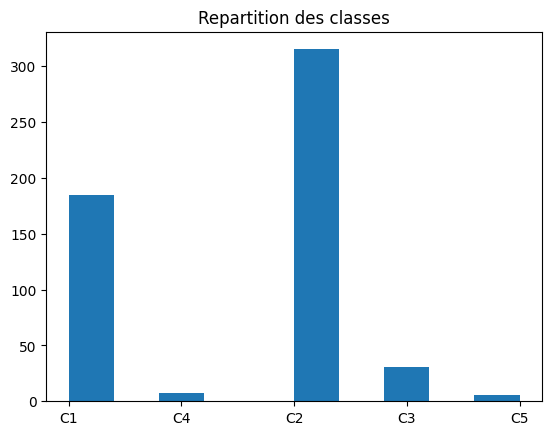

[185, 315, 31, 7, 6]

In [3]:
# Repartition des classes

plt.hist(data['classification_diagnostic'])
plt.title('Repartition des classes')
plt.show()

unique = np.unique(data['classification_diagnostic'])
freq = [np.sum(data['classification_diagnostic'] == classe) for classe in unique]
freq

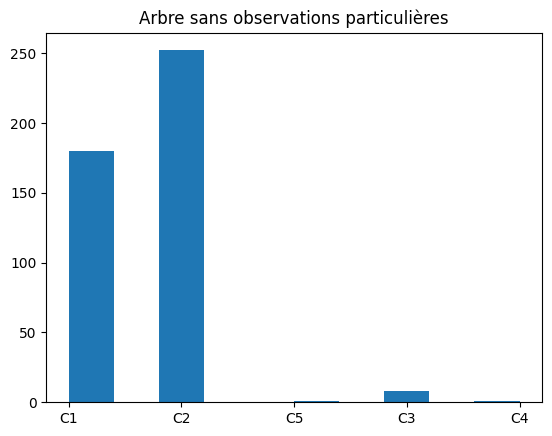

In [4]:
# Arbre sans observations particulières

aucune_obs = data[data['observation_houppier'] == '0']
plt.hist(aucune_obs['classification_diagnostic'])
plt.title('Arbre sans observations particulières')
plt.show()

# On constate que les arbres sans observations particulières sont majoritairements C1 ou C2

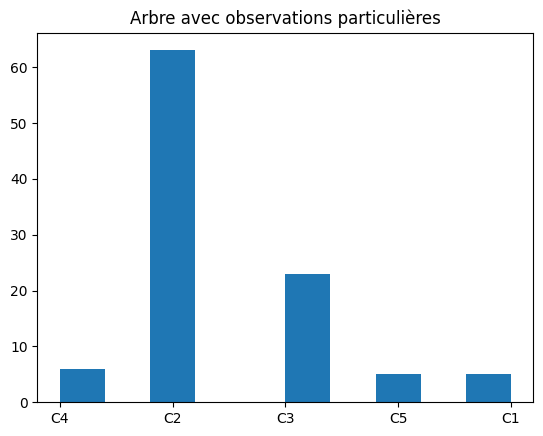

In [5]:
# Arbre avec observations particulières

avec_obs = data[data['observation_houppier'] != '0']
plt.hist(avec_obs['classification_diagnostic'])
plt.title('Arbre avec observations particulières')
plt.show()

# Toujours majorité C2 mais plus de C3, C4 et C5

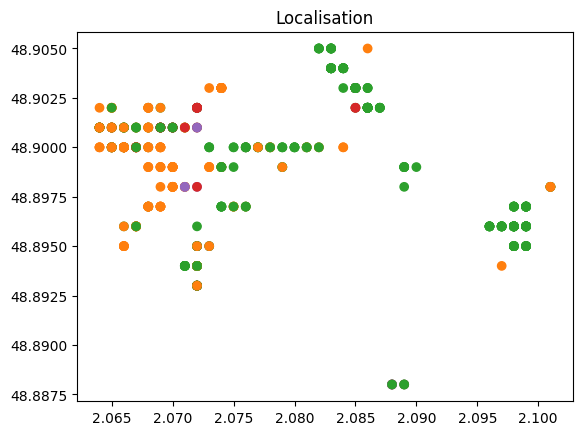

In [6]:
# Localisation

plt.scatter(data['Long'], data['Lat'], c = data['classification_diagnostic'])
plt.title('Localisation')
plt.show()

# L'algorithme des knn peut sembler intéressant MAIS certains arbres ont la même position car ils sont trop proches

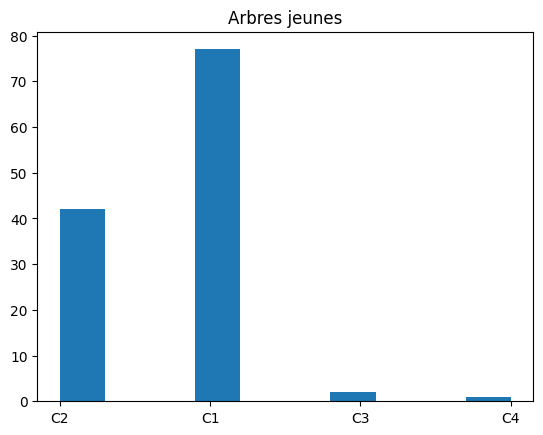

122

In [7]:
arbres_jeunes = data[(data['classe_age'] == 'J')]
plt.hist(arbres_jeunes['classification_diagnostic'])
plt.title('Arbres jeunes')
plt.show()
len(arbres_jeunes)

# les arbres jeune sont quasi-tous C1 ou C2

In [8]:
arbres_murs = data[(data['classe_age'] == 'AM')]
len(arbres_murs)

# Trop peu d'arbre adultes murs pour en conclure des choses (les deux sont C2)

2

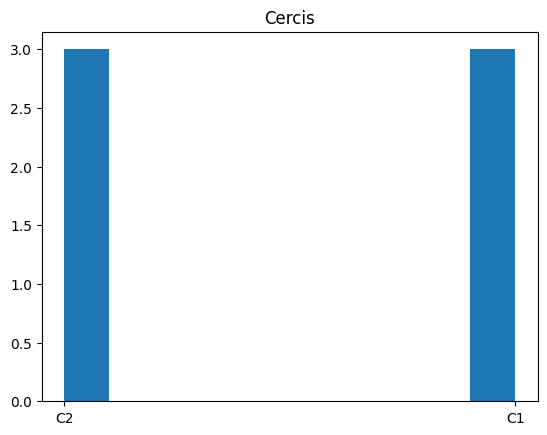

6

In [9]:
plt.hist(data[data['genre_arbre'] == 'Cercis']['classification_diagnostic'])
plt.title('Cercis')
plt.show()
len(data[data['genre_arbre'] == 'Cercis'])

# Les 6 cercis sont tous sain

# Fonctions de base

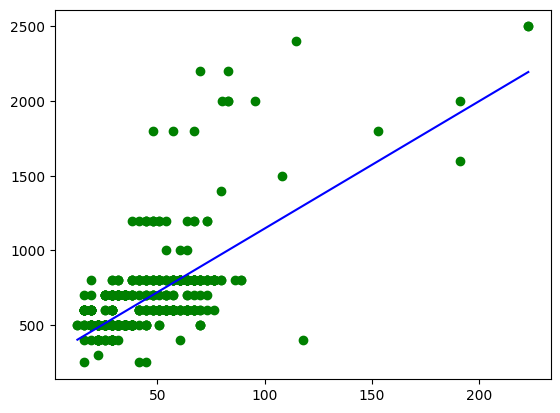

In [10]:
def corr(x,y):
    plt.scatter(x, y, c = 'green')
    b = (np.cov(x,y)[0,1]) / np.var(x)
    a = np.mean(y) - b * np.mean(x)
    plt.plot([np.min(x), np.max(x)],[a + b * np.min(x), a + b * np.max(x)] , c = 'blue')
corr(data['diametre'],data['hauteur'])

# Permet de voir si les variables numériques sont indépendantes (utile pour le NaïveBayes)

In [11]:
def loi_jointe(df, v1, v2):
    x1 = df[v1]
    x2 = df[v2]
    m2 = len(x2.unique())
    m1 = len(x1.unique())
    res = np.zeros([m1, m2])
    print(x2.unique())
    # Car l'ordre des classes n'est pas toujours le même
    print(x1.unique())
    for i in range (m1):
        for j in range (m2):
            res[i,j] = np.mean((x1 == x1.unique()[i]) & (x2 == x2.unique()[j]))
    return res

# Pour l'ordinateur

def tableau(v1):
    return pd.crosstab(data['classification_diagnostic'], data[v1])

# Permet de visualiser les classes (pour nous)

In [12]:
def accuracy(prev):
    return np.mean([prev[i] == data['classification_diagnostic'].iloc[i] \
                   for i in range(len(data))])

# Fonction qui permet d'avoir une estimation sur nos données d'entraînements
# Le résulat sera bien évidemment biaisé
    
# accuracy("prevision sur data")

In [13]:
# CREER FICHIER CSV

def soumettre(fichier):
    prev = {'classification_diagnostic': fichier}
    df = pd.DataFrame(prev)
    df['ID_ARBRE']= prev_data.index
    df = df.set_index('ID_ARBRE')
    df.to_csv('prev.csv',index=True,index_label='ID_ARBRE')
    
#soumettre(nom-prev)

In [14]:
def bayes(var):
    loi = loi_jointe(data,var,'classification_diagnostic')
    res = []
    for i in range (len(loi)):
        res.append(np.argmax(loi[i]))
    return res

# Renvoie la classe majoritaire de chaque groupe

In [15]:
def tab_array(tab):
    res = []
    for i in range (559,699):
        if ((i==598) or (i==614) or (i==670)) :
            continue
        res.append(tab['classification_diagnostic'][i])
    return res
    
#bayes4_sou = tab_array(bayes4_prev)

# Bayes et NaïveBayes

In [16]:
bayes('classe_age')

['C1' 'C4' 'C2' 'C3' 'C5']
['A' 'JA' 'J' 'AM']


[2, 2, 0, 2]

In [17]:
def prev_age(data):
    res = []
    for i in range(len(data)):
        if data['classe_age'].iloc[i] == 'J':
            res.append('C1')
        else:
            res.append('C2')
    return res
    
accuracy(prev_age(data))

0.6433823529411765

In [18]:
bayes('type_sol')

['C1' 'C4' 'C2' 'C3' 'C5']
['MA' 'GR' 'Gr' 'S' 'G' 'CS' 'P' 'TV']


[2, 2, 2, 2, 2, 0, 2, 0]

In [19]:
def prev_sol(data):
    res =[]
    for i in range (len(data)):
        if (data['type_sol'].iloc[i] == 'TV') or (data['type_sol'].iloc[i] == 'CS'):
            res.append('C1')
        else:
            res.append('C2')
    return res
    
accuracy(prev_sol(data))

0.5845588235294118

In [20]:
bayes('plaie_collet')

['C1' 'C4' 'C2' 'C3' 'C5']
['RCPPL' 'RCPLS' 'RCPLC' 'RCPLNC' 'RCPLCF' 'RCPLNS' 'AU']


[0, 2, 2, 2, 1, 2, 3]

In [21]:
def prev_pc(data):
    res =[]
    for i in range (len(data)):
        if (data['plaie_collet'].iloc[i] == 'RCPPL') :
            res.append('C1')
        elif (data['plaie_collet'].iloc[i] == 'RCPLCF') :
            res.append('C4')
        elif (data['plaie_collet'].iloc[i] == 'AU') :
            res.append('C3')
        else:
            res.append('C2')
    return res
    
accuracy(prev_pc(data))

0.6893382352941176

In [22]:
tableau('genre_arbre')

genre_arbre,Acer,Alnus,Betula,Carpinus,Cercis,Corylus,Fraxinus,Magnolia,Ostrya,PhotiniaxFraseri'RedRobin',Prunus,Tilia,Zelkova
classification_diagnostic,,,,,,,,,,,,,
C1,0,0,1,13,3,24,50,0,6,0,2,78,8
C2,23,3,6,18,3,13,18,4,29,7,3,188,0
C3,15,2,0,1,0,1,1,0,1,0,1,9,0
C4,3,0,0,0,0,0,0,0,0,0,3,1,0
C5,3,0,0,0,0,0,1,0,0,0,1,1,0


In [23]:
def prev_bayes1(var, groupe) :
    norm = data['classification_diagnostic'].value_counts(normalize = True)
    return (tableau(var)[groupe] * norm).idxmax()

In [24]:
def bayes_1(data, prev, var) :
    """ Ce code est plus mauvais d'un point de vue de puissance de calcul
    mais est beaucoup plus simple à utiliser"""
    
    labels = np.unique(data['classification_diagnostic'])
    res = pd.DataFrame(index = prev.index, columns = ['classification_diagnostic'])
    for i in prev.index :
        res.loc[i, 'classification_diagnostic'] = prev_bayes1(var,prev.loc[i,var])
    return res
    
#bayes_test = bayes_1(data, data, 'genre_arbre')

In [25]:
def precis(prev, data) :
    return np.mean(prev['classification_diagnostic'] == data['classification_diagnostic'])
    
#precis(bayes_test, data)

# Accuracy pour les tableaux

In [26]:
def prev_bayes_2(var1, var2, groupe1, groupe2) :
    # NaïveBayes suppose l'indépendance
    norm = data['classification_diagnostic'].value_counts(normalize = True)
    return (tableau(var1)[groupe1] * tableau(var2)[groupe2]* norm).idxmax()

In [27]:
def bayes_2(data, prev, var1, var2) :
    labels = np.unique(data['classification_diagnostic'])
    res = pd.DataFrame(index = prev.index, columns = ['classification_diagnostic'])
    for i in prev.index :
        res.loc[i, 'classification_diagnostic'] = prev_bayes_2(var1,var2,prev.loc[i,var1],prev.loc[i,var2])
    return res
    
#bayes2_test = bayes_2(data, data, 'genre_arbre', 'classe_age')
    
#precis(bayes2_test,data)

# On peut prolonger le nombre de variable mais la complexité du code augmente

In [28]:
def prev_bayes_4(var1, var2, var3, var4, groupe1, groupe2, groupe3, groupe4) :
    norm = data['classification_diagnostic'].value_counts(normalize = True)
    return (tableau(var1)[groupe1] * tableau(var2)[groupe2] * tableau(var3)[groupe3] * tableau(var4)[groupe4] * norm).idxmax()

In [29]:
def bayes_4(data, prev, var1, var2, var3, var4) :
    labels = np.unique(data['classification_diagnostic'])
    res = pd.DataFrame(index = prev.index, columns = ['classification_diagnostic'])
    for i in prev.index :
        res.loc[i, 'classification_diagnostic'] = prev_bayes_4(var1,var2,var3,var4,prev.loc[i,var1],prev.loc[i,var2],prev.loc[i,var3], prev.loc[i,var4])
    return res

#bayes4_test = bayes_4(data, data, 'canisse_arbre', 'plaie_houppier', 'plaie_collet', 'plaie_tronc')

#precis(bayes4_test,data)

bayes4_prev = bayes_4(data, prev_data, 'canisse_arbre', 'plaie_houppier', 'plaie_collet', 'plaie_tronc')

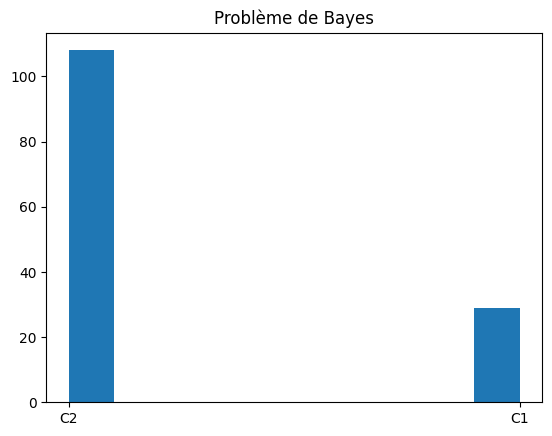

In [30]:
plt.hist(bayes4_prev['classification_diagnostic'])
plt.title('Problème de Bayes')
plt.show()

# Algorithme des Knn

In [31]:
def knn(k,df,var1,var2,point):
    x0, y0 = point
    x = df[var1]
    y = df[var2]
    dist = [np.sqrt((x.iloc[i]-x0)**2 + (y.iloc[i]-y0)**2) for i in range (len(df))] 
    #Récupère les rangs des distances par ordre croissant
    rang = np.argsort(dist)  
    #Récupère les k plus proches voisins
    li = [val for val in rang[:k]]
    #Récupère les classes
    knn0 = [df['classification_diagnostic'].iloc[n] for n in li]
    x = np.array(knn0)
    unique, counts = np.unique(x, return_counts=True)
    maj = np.argmax(counts)
    return unique[maj]

In [32]:
def prev_knn(k, df, var1, var2, prev):
    res = []
    for i in range(len(prev)):
        x0 = prev[var1].iloc[i]
        y0 = prev[var2].iloc[i]
        res.append(knn(k,df , var1, var2, (x0, y0)))
    return res 

In [33]:
# Précision pour une partie des données en cas de découpage

def accuracy_2(prev, data):
    return np.round(np.mean([prev[i] == data['classification_diagnostic'].iloc[i] \
                   for i in range(len(data))]),3)

In [34]:
def meilleur_k(Min,Max, train, test):
    x = []
    y = []
    for i in range(Min,Max+1):
        y0 = accuracy_2(prev_knn(i, train, 'Long', 'Lat', test), test)
        print ("k =",i,"==> précision =",y0)
        x.append(i)
        y.append(y0)
    print("") #Retour à la ligne
    plt.plot(x, y, marker='o')
    plt.title("Meilleur_k")
    plt.show

In [35]:
#Validation croisée

train1 = data[0:422]
test1 = data[422:558]

train2 = pd.concat([data[0:136],data[272:558]])
test2 = data[136:272]

train3 = pd.concat([data[0:272],data[408:558]])
test3 = data[272:408]

train4 = data[136:558]
test4 = data[0:136]

k = 6 ==> précision = 0.738
k = 7 ==> précision = 0.746
k = 8 ==> précision = 0.779
k = 9 ==> précision = 0.779
k = 10 ==> précision = 0.779
k = 11 ==> précision = 0.779
k = 12 ==> précision = 0.754
k = 13 ==> précision = 0.754
k = 14 ==> précision = 0.754
k = 15 ==> précision = 0.738

k = 6 ==> précision = 0.75
k = 7 ==> précision = 0.757
k = 8 ==> précision = 0.779
k = 9 ==> précision = 0.779
k = 10 ==> précision = 0.772
k = 11 ==> précision = 0.772
k = 12 ==> précision = 0.787
k = 13 ==> précision = 0.809
k = 14 ==> précision = 0.809
k = 15 ==> précision = 0.801

k = 6 ==> précision = 0.721
k = 7 ==> précision = 0.706
k = 8 ==> précision = 0.721
k = 9 ==> précision = 0.713
k = 10 ==> précision = 0.721
k = 11 ==> précision = 0.735
k = 12 ==> précision = 0.765
k = 13 ==> précision = 0.743
k = 14 ==> précision = 0.735
k = 15 ==> précision = 0.743

k = 6 ==> précision = 0.721
k = 7 ==> précision = 0.757
k = 8 ==> précision = 0.757
k = 9 ==> précision = 0.757
k = 10 ==> précision = 0.757

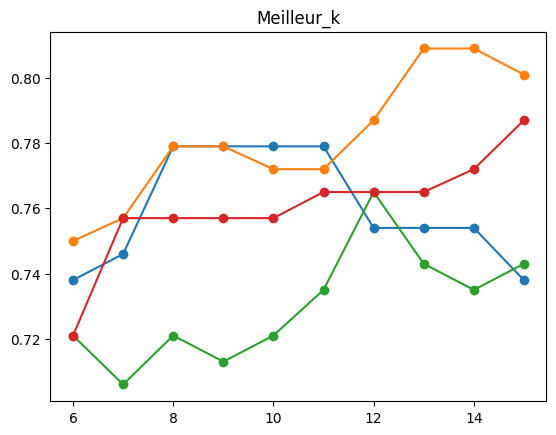

In [36]:
meilleur_k(6, 15, train1, test1)
meilleur_k(6, 15, train2, test2)
meilleur_k(6, 15, train3, test3)
meilleur_k(6, 15, train4, test4)

In [37]:
accuracy(prev_knn(12, data, 'Long', 'Lat', data))

0.7702205882352942

In [38]:
def knn_1var(k,var1,point):
    x = data[var1]
    dist = [(x.iloc[i]-point)**2 for i in range (len(data))]
    #Récupère les rangs des distances par ordre croissant
    rang = np.argsort(dist)
    #Récupère les k plus proches voisins
    li = [val for val in rang[:k]]
    #Récupère les classes
    knn0 = [data['classification_diagnostic'].iloc[n] for n in li]
    x = np.array(knn0)
    unique, counts = np.unique(x, return_counts=True)
    maj = np.argmax(counts)
    return unique[maj]

In [39]:
def prev_knn1(k, var1, prev):
    res = []
    for i in range(len(prev)):
        x0 = prev[var1].iloc[i]
        res.append(knn_1var(k, var1, x0))
    return res

In [40]:
accuracy(prev_knn1(5,'diametre',data))

0.7095588235294118

In [41]:
def knn_3(k, df, var1, var2, var3, point):
    x0, y0, z0 = point
    x = df[var1]
    y = df[var2]
    z = df[var3]
    dist = [np.sqrt((x.iloc[i] - x0)**2 + (y.iloc[i] - y0)**2 + (z.iloc[i] - z0)**2) for i in range(len(df))]
    rang = np.argsort(dist)
    li = [val for val in rang[:k]]
    knn0 = [df['classification_diagnostic'].iloc[n] for n in li]
    x = np.array(knn0)
    unique, counts = np.unique(x, return_counts=True)
    maj = np.argmax(counts)
    
    return unique[maj]

In [42]:
def prev_knn_3(k, df, var1, var2, var3, prev):
    res = []
    for i in range(len(prev)):
        x0 = prev[var1].iloc[i]
        y0 = prev[var2].iloc[i]
        z0 = prev[var3].iloc[i]
        res.append(knn_3(k, df, var1, var2, var3, (x0, y0, z0)))
    return res

In [43]:
accuracy(prev_knn_3(6, data, 'diametre','circonference (en cm)','hauteur',data))

0.75

In [44]:
def classe_majoritaire(data):
    unique, counts = np.unique(data, return_counts=True)
    maj = np.argmax(counts)
    return unique[maj]
classe_majoritaire(data['classification_diagnostic'])

'C2'

# Arbre de décision

In [45]:
def gini(df, var):
    valeurs, counts = np.unique(df, return_counts=True)
    proba = counts / np.sum(counts)
    return np.sum(proba * (1 - proba))

In [46]:
def separer_donnees(data, y, var, seuil):
    # Boucle pour parcourir les seuils
    # Condition pour modifier
    seuil = new_seuil
    gauche = data[var] <= seuil
    droit = data[var] > seuil
    return var, seuil, droit, gauche

In [47]:
def arbre_decision(data):
    if (np.mean(data['classificication_diagnostic'] == classe_majoritaire(data['classification_diagnostic'])) > 0.90):
        return classe_majoritaire(data)
    else:
        j, s, data_d, data_g = separer_donnees(data,var)
        arbre_g = arbre_decision(data_g)
        arbre_d = arbre_decision(data_d)
        return (j, s, arbre_g, arbre_d)
    

In [48]:
def aleatoire(n):
    # Génère un nombre aléatoire entre 0 et n pour découper les données
    return int(np.random.rand()*n+1)%n
aleatoire(450)

252